## Project 1 - Mobile Home Parks and Tornadoes Risk Assessment in the US.

   ### Objective: 

   #### Assess the risk of tornado occurrences for mobile home parks in the US. Tornadoes pose a significant threat to mobile home parks due to their vulnerability to high winds and flying debris. By analyzing historical tornado data and the spatial distribution of mobile home parks, the project aims to identify high-risk areas and provide recommendations for mitigation strategies.

### Step 1: Imported Libraries: Pandas, geopandas, shapely, matplotlib, geoviews, hvplot, numpy and scipy

In [36]:

# Imported Libraries: Pandas, geopandas, shapely, matplotlib, geoviews, hvplot, numpy and scipy

# import dependencies

import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import geoviews as gv
import geoviews.tile_sources as gvts
import hvplot.pandas
import matplotlib.colors as mcolors
import numpy as np
from scipy.stats import linregress


### Step 2: Define file paths and read data from both CSV's

In [ ]:

# Define file paths and read data from both CSV's

# define paths for both files

tornadoes_data_path = "1950-2021_all_tornadoes.csv"
mobile_home_parks_path = "Mobile_Home_Parks.csv"

# Read the data from both csv's 

tornadoes_data = pd.read_csv(tornadoes_data_path)
mobile_home_data = pd.read_csv(mobile_home_parks_path)

display(tornadoes_data)
display(mobile_home_data) 


### Step 3: Cleaning and renaming the data for both CSV files (for later merging)

In [ ]:

# Cleaning and renaming the data for both CSV files (for later merging)

# Rename columns in tornadoes_data
clean_tornadoes_data = tornadoes_data.rename(columns={
    "yr": "year",
    "mo": "month",
    "dy": "day",
    "st": "state",
    "mag": "magnitude",
    "inj": "injuries",
    "fat": "fatalities",
    "loss": "propertyloss",
    "closs": "lossinmillions",
    "slat": "latitude",
    "slon": "longitude",
    "elat": "latitudeend",
    "elon": "longitudeend",
    "len": "lengthinmiles",
    "wid": "widthinyards",
    })
# Delete columns in tornadoes_data
clean_tornadoes_data = clean_tornadoes_data.drop(columns={"om","tz","stf","stn","ns","sn","sg","f1","f2","f3","f4","fc"})
clean_tornadoes_data = clean_tornadoes_data[(clean_tornadoes_data['latitude'] != 0) | (clean_tornadoes_data['longitude'] != 0)]
clean_tornadoes_data['latitude'] = clean_tornadoes_data['latitude'].round(1)
clean_tornadoes_data['longitude'] = clean_tornadoes_data['longitude'].round(1)
display(clean_tornadoes_data)
# Rename columns in mobile_home_data
clean_mobile_home_data = mobile_home_data.rename(columns={
    "NAME": "name",
    "ADDRESS": "address",
    "CITY": "city",
    "STATE": "state",
    "ZIP": "zipcode",
    "TELEPHONE": "telephone",
    "TYPE": "type",
    "STATUS": "status",
    "COUNTY": "county",
    "LATITUDE": "latitude",
    "LONGITUDE": "longitude"
    })
# Delete columns in mobile home parks data
clean_mobile_home_data = clean_mobile_home_data.drop(columns={
"X", "Y", "FID", "MHPID", "ADDRESS2", "ZIP4", "COUNTYFIPS",
"COUNTRY", "NAICS_CODE", "NAICS_DESC", "SOURCE",
"SOURCEDATE", "VAL_METHOD", "VAL_DATE", "WEBSITE","index",
"UNITS", "SIZE", "YEARBLT", "RevGeoFlag"})
clean_mobile_home_data = clean_mobile_home_data[(clean_mobile_home_data['latitude'] != 0) | (clean_mobile_home_data['longitude'] != 0)]
# Round coordinates to 4 decimal places
clean_mobile_home_data['latitude'] = clean_mobile_home_data['latitude'].round(1)
clean_mobile_home_data['longitude'] = clean_mobile_home_data['longitude'].round(1)
display(clean_mobile_home_data)

### Step 4: Merging data from both data sets, based on coordenates.

In [ ]:
# Merging data from both data sets, based on coordenates.

tornado_mobiles_merge = pd.merge(clean_tornadoes_data, clean_mobile_home_data, left_on=["longitude","latitude"],right_on=["longitude","latitude"])
merge_data_df = pd.DataFrame(tornado_mobiles_merge)

# Export the tornado_mobiles_merge data into a csv
merge_data_df.to_csv("../Project1Bootcamp/tornadoesandparksmerged.csv")

merge_data_df

### Step 5: Plot the number of tornadoes vs years

In [ ]:

# Formats the 'year' column to datetime format for further processing
clean_tornadoes_data['year'] = pd.to_datetime(clean_tornadoes_data['year'], format='%Y')

# Group the data by year and calculate the tornado count for each year
tornadoes_by_year = clean_tornadoes_data.groupby(clean_tornadoes_data['year'].dt.year).size()

# Plot the tornado count over time
plt.figure(figsize=(10, 6))
plt.plot(tornadoes_by_year.index, tornadoes_by_year.values, marker='o', linestyle='-')
plt.title('Tornado Count by Year')
plt.xlabel('Year')
plt.ylabel('Tornado Count')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

##### Graph 1: From 1950 to 2021, a total of 68739 tornadoes were registered in the US. An increasing tornado tendency over time in the US can be observed in the shown graph.

### Step 6: Calculate and plot the distribution of tornadoes based on the Fujita Scale Category, scale for rating tornado intensity, 
### based primarily on the damage tornadoes inflict on human-built structures and vegetation.

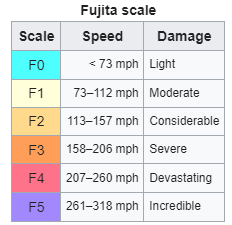

In [ ]:

# Define a dictionary to map magnitudes from database to Fujita scale categories
fujita_scale_map = {0: 'F0', 1: 'F1', 2: 'F2', 3: 'F3', 4: 'F4', 5: 'F5'}

# Apply the mapping to create the 'fujita_scale_category' column
clean_tornadoes_data['fujita_scale_category'] = clean_tornadoes_data['magnitude'].map(fujita_scale_map)

# Calculate the distribution of the Fujita scale category
fujita_scale_distribution = clean_tornadoes_data['fujita_scale_category'].value_counts()

# Calculate the percentage of each category
percentage = (fujita_scale_distribution / fujita_scale_distribution.sum()) * 100

# Plot a bar chart to show the distribution of the Fujita scale category
plt.figure(figsize=(10, 6))
bars = fujita_scale_distribution.plot(kind='bar', color='skyblue')
plt.title('Distribution of Tornadoes by Fujita Scale Category')
plt.xlabel('Fujita Scale Category')
plt.ylabel('Tornado Count')
plt.xticks(rotation=0)  # Rotate x-axis labels if needed
plt.grid(axis='y')  # Add grid lines to the y-axis

# Annotate bars with percentage values
for i, val in enumerate(fujita_scale_distribution):
    plt.text(i, val + 5, f'{percentage[i]:.2f}%', ha='center')
plt.show()

### Step 7: Count tornado ocurrences by state and visualize top 10 most affected states.

In [ ]:

# Count occurrences of tornadoes by state and sort from highest to lowest
tornado_count_by_state = clean_tornadoes_data["state"].value_counts().sort_values(ascending=False)

# Visualize the top 10 states most affected by tornadoes
top_affected_states = tornado_count_by_state.head(10)

# Plot in a horizontal bar chart
plt.figure(figsize=(10, 6))
tornado_count_by_state.head(10).sort_values().plot(kind='barh', color='skyblue')
plt.title('Top 10 US States Most Affected by Tornadoes')
plt.xlabel('Number of Tornadoes')
plt.ylabel('State')
plt.show()

In [ ]:
# Total number of victims (injured and fatalities) by state
tornado_victims_by_state = clean_tornadoes_data.groupby('state')[['injuries', 'fatalities']].sum()

# Select the top ten states with the highest total number of victims
top_10_states = tornado_victims_by_state.sum(axis=1).nlargest(10).index
tornado_victims_top_10 = tornado_victims_by_state.loc[top_10_states]

# Visualize the total number of victims (injured and fatalities) by state in a horizontal bar chart
plt.figure(figsize=(10, 8))
bar_width = 0.4
index = np.arange(len(tornado_victims_top_10))
plt.barh(index, tornado_victims_top_10['injuries'], bar_width, label='Injured', color='skyblue')
plt.barh(index + bar_width, tornado_victims_top_10['fatalities'], bar_width, label='Fatalities', color='salmon')
plt.xlabel('Number of Victims')
plt.ylabel('State')
plt.title('Total Number of Victims by State (Top 10)')
plt.yticks(index + bar_width / 2, tornado_victims_top_10.index)
plt.legend()
plt.gca().invert_yaxis()  # Invert the y-axis so that states appear in descending order
plt.tight_layout()
plt.show()

## Code for printing map with all of the low-risk sites

In [ ]:
# Using Groupby to add tornado counts to matching locations on the merge_data_df
tornado_count_by_location = merge_data_df.groupby(['latitude', 'longitude']).size().reset_index(name='tornado_count')
print(tornado_count_by_location)

# Step 1: Calculate Tornado Count by Location
tornado_count_by_location['yearly_average'] = tornado_count_by_location['tornado_count'] / 71
print(tornado_count_by_location)


In [ ]:
# Define risk thresholds
low_threshold = 1
moderate_threshold = 3
high_threshold = 6

# Classify yearly average tornado counts into risk scale
def classify_tornado_risk(yearly_average):
    if yearly_average <= low_threshold:
        return 'Low Risk'
    elif yearly_average <= moderate_threshold:
        return 'Moderate Risk'
    elif yearly_average <= high_threshold:
        return 'High Risk'
    else:
        return 'Very High Risk'

# Add a new column 'risk_category' to tornado_count_by_location DataFrame
tornado_count_by_location['risk_category'] = tornado_count_by_location['yearly_average'].apply(classify_tornado_risk)

# Display the updated DataFrame
print(tornado_count_by_location)


In [ ]:
# Define custom colors for risk categories
risk_colors = {
    'Low Risk': 'green',
}

# Filter locations with risk category other than "Low Risk"
high_risk_locations = tornado_count_by_location[tornado_count_by_location['risk_category'] == 'Low Risk']

# Plot the map using hvplot with geo=True and OSM tiles
risk_map1 = high_risk_locations.hvplot(
    kind='points',
    x='longitude',
    y='latitude',
    c='risk_category',
    tiles='OSM',
    colorbar=True,
    cmap=mcolors.ListedColormap([risk_colors[r] for r in risk_colors if r == 'Low Risk']),
    frame_width=800,
    frame_height=600,
    title='Tornado Risk Classification',
    geo=True,
)

# Display the map
risk_map1

## Code for printing map with moderate, high, and very high risk sites

In [ ]:
# Define custom colors for risk categories
risk_colors = {
    'Moderate Risk': 'blue',
    'High Risk': 'orange',
    'Very High Risk': 'red'
}

# Filter locations with risk category other than "Low Risk"
high_risk_locations = tornado_count_by_location[tornado_count_by_location['risk_category'] != 'Low Risk']

# Plot the map using hvplot with geo=True and OSM tiles
risk_map2 = high_risk_locations.hvplot(
    kind='points',
    x='longitude',
    y='latitude',
    c='risk_category',
    tiles='OSM',
    colorbar=True,
    cmap=mcolors.ListedColormap([risk_colors[r] for r in risk_colors if r != 'Low Risk']),
    frame_width=800,
    frame_height=600,
    title='Tornado Risk Classification',
    geo=True,
)

# Display the map
risk_map2


In [ ]:
# Scatter plot
plt.scatter(merge_data_df['year'], y_test, label='Actual')
plt.scatter(merge_data_df['year'], y_pred, color='red', label='Predicted')

# Add linear regression line
slope, intercept, rvalue, pvalue, stderr = linregress(X_test['year'], y_test)
regress_values = merge_data_df['year'] * slope + intercept
line_eq = "y = " + str(round(slope, 2)) + "x + " + str(round(intercept, 2))
plt.plot(merge_data_df['year'], regress_values, "r-", label=line_eq)

# Add labels and legend
plt.xlabel('Year')
plt.ylabel('Tornado Occurrences')
plt.title('Linear Regression: Tornado Occurrences vs Year')
plt.legend()

plt.show()